# Training machine learning models 

## <a id='toc1_'></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

## <a id='toc3_'></a>[Setting Up the Environment](#toc0_)

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import keras_tuner as kt
import ast
import numpy as np

This is the preprocessed dataset from phase 1.

In [3]:
data = pd.read_csv('dataset.csv')
data.head(5)

,track_name,album_name,artists,explicit,key,mode,time_signature,danceability,energy,loudness,...,week_of_year,day,day_of_week,day_of_year,duration_mins,duration_ms,artist_count,genre_count,track_genre,popularity
0,Ode To The Mets,The New Abnormal,['The Strokes'],False,1,0,4.0,0.4280,0.617,-5.424,...,15,10,Friday,101,5.863117,351787,1,2,"['alt-rock', 'garage']",67
1,Glaciers,Bloom,['Lights & Motion'],False,7,1,4.0,0.0789,0.160,-18.144,...,5,2,Friday,33,2.939550,176373,1,1,['ambient'],49
2,Uber Pussy,Pink Season,['Pink Guy'],True,7,1,4.0,0.8700,0.597,-6.320,...,1,4,Wednesday,4,1.956017,117361,1,1,['comedy'],39
3,2002,Speak Your Mind (Deluxe),['Anne-Marie'],False,1,0,4.0,0.6970,0.683,-2.881,...,17,27,Friday,117,3.116450,186987,1,3,"['dance', 'house', 'pop']",82
4,Monsters You Made (feat. Chris Martin),Twice As Tall,"['Burna Boy', 'Chris Martin']",True,7,0,4.0,0.6710,0.646,-7.513,...,33,13,Thursday,226,3.625683,217541,2,1,['dancehall'],45


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        4724 non-null   object 
 1   album_name        4724 non-null   object 
 2   artists           4724 non-null   object 
 3   explicit          4724 non-null   bool   
 4   key               4724 non-null   int64  
 5   mode              4724 non-null   int64  
 6   time_signature    4724 non-null   float64
 7   danceability      4724 non-null   float64
 8   energy            4724 non-null   float64
 9   loudness          4724 non-null   float64
 10  speechiness       4724 non-null   float64
 11  acousticness      4724 non-null   float64
 12  instrumentalness  4724 non-null   float64
 13  liveness          4724 non-null   float64
 14  valence           4724 non-null   float64
 15  tempo             4724 non-null   float64
 16  track_id          4724 non-null   object 


Remove ID columns because they are not useful for the model.

In [5]:
data = data.drop(['track_id', 'album_id', 'artist_ids'], axis=1)

In [6]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
release_date: object
day_of_week: object
track_genre: object


As we extracted the date information, we can remove the original date columns.

In [7]:
data = data.drop(['release_date'], axis=1)

In [8]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object
day_of_week: object
track_genre: object


In [9]:
data['track_genre'] = data['track_genre'].apply(lambda x: ast.literal_eval(x))
data['artists'] = data['artists'].apply(lambda x: ast.literal_eval(x))

In [10]:
genres = set()
for genre_list in data['track_genre']:
    for genre in genre_list:
        genres.add(genre)
print(f'Unique genres: {len(genres)}')

Unique genres: 111


In [11]:
genre_counts = {}
for genre_list in data['track_genre']:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1
i = 0
for genre, count in genre_counts.items():
    if(count > 5):
        i += 1
print(f'Genres with more than 20 tracks: {i}')

Genres with more than 20 tracks: 104


In [12]:
mlb = MultiLabelBinarizer()

one_hot_genres = mlb.fit_transform(data['track_genre'])
one_hot_df = pd.DataFrame(one_hot_genres, columns=mlb.classes_)
data = pd.concat([data, one_hot_df], axis=1)
data = data.drop(columns=['track_genre'])

In [13]:
data['day_of_week'] = data['day_of_week'].astype(pd.StringDtype())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Columns: 142 entries, track_name to world-music
dtypes: bool(1), float64(11), int32(111), int64(15), object(3), string(1)
memory usage: 3.1+ MB


In [14]:
onehotencoder = OneHotEncoder()
day_of_week_encoded = onehotencoder.fit_transform(data[['day_of_week']]).toarray()
day_of_week_encoded_df = pd.DataFrame(day_of_week_encoded, columns=onehotencoder.get_feature_names_out(['day_of_week']))
data = pd.concat([data, day_of_week_encoded_df], axis=1)
data.drop(columns=['day_of_week'], inplace=True)

In [15]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

track_name: object
album_name: object
artists: object


In [16]:
data = data.drop(columns=['track_name', 'album_name', 'artists'])

In [17]:
X = data.drop(columns=['popularity'])
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = data['popularity']

### Part 3: Dimensionality Reduction

**Principal Component Analysis (PCA)**

In [18]:
pca = PCA(n_components=0.9, random_state=31)
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_
X_reduced_df = pd.DataFrame(X_reduced, columns=[f'PC{i}' for i in range(1, X_reduced.shape[1] + 1)])

# print(selected_columns)
print("Number of columns after PCA reduction:", X_reduced_df.columns.size)
print("Number of columns in the origianl Dataset:", X.columns.size)
print("Reduction Ratio", X_reduced_df.columns.size / X.columns.size, "\n")

Number of columns after PCA reduction: 104
Number of columns in the origianl Dataset: 144
Reduction Ratio 0.7222222222222222 



In [19]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum[-1]
# cumsum.sum()

0.9020223786319814

In [20]:
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i}' for i in range(1, len(pca.explained_variance_) + 1)],
    'Explained Variance': pca.explained_variance_,
    'Explained Variance Ratio': pca.explained_variance_ratio_
})

# Print the DataFrame
print(variance_df)

    Principal Component  Explained Variance  Explained Variance Ratio
0                   PC1            4.838659                  0.033595
1                   PC2            3.596305                  0.024969
2                   PC3            3.238701                  0.022486
3                   PC4            2.896871                  0.020113
4                   PC5            2.791129                  0.019379
..                  ...                 ...                       ...
99                PC100            0.744685                  0.005170
100               PC101            0.735169                  0.005104
101               PC102            0.719735                  0.004997
102               PC103            0.711971                  0.004943
103               PC104            0.700686                  0.004865

[104 rows x 3 columns]


In [21]:
print("Correspondnig variances of each feature with the first PCA component:")
selected_columns = X.columns[pca.components_[0].argsort()[::-1]]
for col in selected_columns:
    print(f"    - {col}: {pca.components_[0][X.columns.get_loc(col)]}")

Correspondnig variances of each feature with the first PCA component:
    - day_of_year: 0.3100810362952056
    - month: 0.30234663757369623
    - year: 0.29043561996212974
    - quarter: 0.2899397195271311
    - decade: 0.2831217052211474
    - loudness: 0.25217831343482444
    - day_of_week_Friday: 0.19524542327175887
    - day: 0.18371866764421438
    - week_of_year: 0.18346299687566914
    - energy: 0.17965672990920506
    - genre_count: 0.14473883862528797
    - house: 0.13801926842073456
    - danceability: 0.12351131597472678
    - electro: 0.11739382990780108
    - edm: 0.11728640262037959
    - explicit: 0.11570427796856289
    - reggaeton: 0.09119621204785922
    - artist_count: 0.09034304767523739
    - latino: 0.0883848062833158
    - progressive-house: 0.08521638739618613
    - speechiness: 0.08312672558739721
    - reggae: 0.07976567391028785
    - dance: 0.07843266864107538
    - emo: 0.07540842681902549
    - dubstep: 0.07399467895779505
    - dub: 0.06720806250019806
 

In [22]:
categorical_features = data.select_dtypes(exclude=['int', 'float']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

X_processed = preprocessor.fit_transform(X)

In [23]:
print(categorical_features)

Index(['explicit'], dtype='object')


### Train and Test Data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3779, 146), (945, 146), (3779,), (945,))

In [25]:
non_numeric_cols = data.select_dtypes(exclude=['int', 'float', 'bool']).columns
for col in non_numeric_cols:
    print(f'{col}: {data[col].dtype}')

In [26]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 128 neurons
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
    Dropout(0.2),  # Dropout layer
    Dense(32, activation='relu'),  # Third hidden layer with 32 neurons
    Dense(1)  # Output layer with 1 neuron for regression
])

model.compile(optimizer='adam',
              loss='mean_squared_error',  # MSE is a common loss function for regression
              metrics=['mean_absolute_error'])  # MAE is a useful metric for regression

c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
def fit_and_predict(model, X_train, y_train, X_test, y_test, epochs=20, validation_split=0.2, batch_size=10):
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size)
    y_pred = model.predict(X_test)

    return history, y_pred

In [28]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    history, y_pred = fit_and_predict(model, X_train, y_train, X_test, y_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title('True vs Predicted Popularity')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [29]:
evaluate_model(model, X_train, y_train, X_test, y_test)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])), loss='mse', metrics=['mse'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='tune_keras')

tuner.search(X_train, y_train, epochs=15, validation_split=0.2, batch_size=32)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units_1')},
the second layer is {best_hps.get('units_2')}, the third layer is {best_hps.get('units_3')}, and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

model = tuner.hypermodel.build(best_hps)

Reloading Tuner from my_dir\tune_keras\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first layer is 256,
the second layer is 128, the third layer is 64, and the optimal learning rate for the optimizer
is 0.0001.



c:\Users\Mr. Hajiheideri\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1811.0292 - mse: 1811.0292 - val_loss: 342.1676 - val_mse: 342.1676
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 293.9232 - mse: 293.9232 - val_loss: 221.7014 - val_mse: 221.7014
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 201.2887 - mse: 201.2887 - val_loss: 170.6624 - val_mse: 170.6624
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 157.6930 - mse: 157.6930 - val_loss: 147.7319 - val_mse: 147.7319
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131.1061 - mse: 131.1061 - val_loss: 129.2825 - val_mse: 129.2825
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117.6374 - mse: 117.6374 - val_loss: 122.8655 - val_mse: 122.8655
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 110.2736 - mse: 110.2736 - val_loss: 118.2239 - val_mse: 118.2239
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 101.9193 - mse: 101.9193 - val_loss: 115.3918 - val_mse:

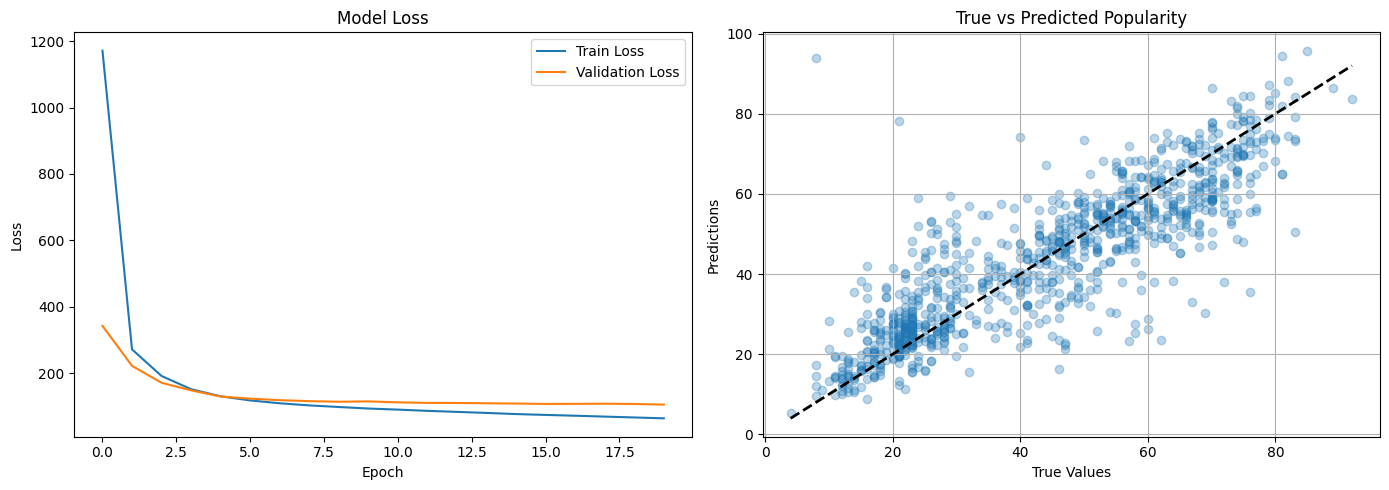

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test)